# **Setup Pustaka**

In [9]:
# !pip install numpy
# !pip install niapy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from niapy.algorithms.basic import LionOptimizationAlgorithm
from niapy.task import Task
from niapy.problems import Problem
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

In [10]:
import niapy
print(niapy.__version__)

2.6.1


# **Load Dataset (Train & Test)**

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# Pisahkan fitur dan label
X_train_scaled = train.drop("y_raw", axis=1)
y_train = train["y_raw"]
X_test_scaled = test.drop("y_raw", axis=1)
y_test = test["y_raw"]
convergence_results = {}

print("✅ Data berhasil dimuat.")
print("Train shape:", X_train_scaled.shape, "| Test shape:", X_test_scaled.shape)

✅ Data berhasil dimuat.
Train shape: (130, 1109) | Test shape: (57, 1109)


# **Seleksi Fitur LOA dengan Random Forest**

In [13]:
# =========================================
# Definisi Kelas LOA Feature Selection (Random Forest) - (UPDATED DENGAN CV)
# =========================================
class LOAFeatureSelectionRF(Problem):
    def __init__(self, X, y, alpha=0.9):
        super().__init__(dimension=X.shape[1], lower=0, upper=1)
        self.X = X.values
        self.y = y.values
        self.alpha = alpha
        self.model = RandomForestClassifier(n_estimators=100, random_state=42)

    def _evaluate(self, x):
        selected_mask = x > 0.5
        num_features = np.sum(selected_mask)

        if num_features == 0:
            return float('inf')

        X_subset_all = self.X[:, selected_mask]

        try:
            scores = cross_val_score(
                self.model, X_subset_all, self.y, cv=3, scoring='accuracy', n_jobs=-1
            )
            accuracy = np.mean(scores)
        except ValueError:
            accuracy = 0.0

        total_features = self.X.shape[1]

        fitness = self.alpha * (1 - accuracy) + (1 - self.alpha) * (num_features / total_features)
        return fitness

# =========================================
# Inisialisasi LOA dan Jalankan Seleksi (RF)
# =========================================
print("Memulai Proses LOA (Random Forest)...")
problem_rf = LOAFeatureSelectionRF(X_train_scaled, y_train, alpha=0.7)
task_rf = Task(problem=problem_rf, max_evals=1500)

algorithm_rf = LionOptimizationAlgorithm(
    population_size=50,
    pride_ratio=0.8,
    mating_prob=0.3,
    roaming_prob=0.2,
    migration_rate=0.1,
    seed=42
)

best_features_mask_rf, best_fitness_rf = algorithm_rf.run(task_rf)
convergence_results["LOA-RF"] = task_rf.convergence_data()

print(f"✅ Proses LOA (Random Forest) selesai!")
print(f"Nilai fitness terbaik: {best_fitness_rf:.4f}")

selected_mask_rf = best_features_mask_rf > 0.5
selected_features_rf = X_train_scaled.columns[selected_mask_rf]
print(f"Jumlah fitur terpilih oleh LOA (RF): {len(selected_features_rf)}")
X_train_rf = X_train_scaled[selected_features_rf]
X_test_rf = X_test_scaled[selected_features_rf]
print(f"Shape data training setelah LOA (RF): {X_train_rf.shape}")

Memulai Proses LOA (Random Forest)...
✅ Proses LOA (Random Forest) selesai!
Nilai fitness terbaik: 0.1981
Jumlah fitur terpilih oleh LOA (RF): 96
Shape data training setelah LOA (RF): (130, 96)


In [14]:
import os

save_dir = "/content/drive/MyDrive/TA_Features_Trial24/"
os.makedirs(save_dir, exist_ok=True)

pd.Series(selected_features_rf).to_csv(os.path.join(save_dir, "selected_features_rf.csv"), index=False)
X_train_rf.to_csv(os.path.join(save_dir, "X_train_rf.csv"), index=False)
X_test_rf.to_csv(os.path.join(save_dir, "X_test_rf.csv"), index=False)

print(f"✅ Hasil LOA-RF berhasil disimpan ke: {save_dir}")

✅ Hasil LOA-RF berhasil disimpan ke: /content/drive/MyDrive/TA_Features_Trial24/


# **Seleksi Fitur LOA dengan AdaBoost**

In [15]:
# =========================================
# Definisi Kelas LOA Feature Selection (AdaBoost) - (UPDATED DENGAN CV)
# =========================================
class LOAFeatureSelectionAB(Problem):
    def __init__(self, X, y, alpha=0.9):
        super().__init__(dimension=X.shape[1], lower=0, upper=1)
        self.X = X.values
        self.y = y.values
        self.alpha = alpha
        self.model = AdaBoostClassifier(n_estimators=50, random_state=42)

    def _evaluate(self, x):
        selected_mask = x > 0.5
        num_features = np.sum(selected_mask)

        if num_features == 0:
            return float('inf')

        X_subset_all = self.X[:, selected_mask]
        try:
            scores = cross_val_score(
                self.model, X_subset_all, self.y, cv=3, scoring='accuracy', n_jobs=-1
            )
            accuracy = np.mean(scores)
        except ValueError:
            accuracy = 0.0
        total_features = self.X.shape[1]

        fitness = self.alpha * (1 - accuracy) + (1 - self.alpha) * (num_features / total_features)
        return fitness

# =========================================
# Inisialisasi LOA dan Jalankan Seleksi (AdaBoost)
# =========================================
print("\nMemulai Proses LOA (AdaBoost)...")
problem_ab = LOAFeatureSelectionAB(X_train_scaled, y_train, alpha=0.7)

task_ab = Task(problem=problem_ab, max_evals=1500)

algorithm_ab = LionOptimizationAlgorithm(
    population_size=50,
    pride_ratio=0.8,
    mating_prob=0.3,
    roaming_prob=0.2,
    migration_rate=0.1,
    seed=42
)

best_features_mask_ab, best_fitness_ab = algorithm_ab.run(task_ab)
convergence_results["LOA-AB"] = task_ab.convergence_data()

print(f"✅ Proses LOA (AdaBoost) selesai!")
print(f"Nilai fitness terbaik: {best_fitness_ab:.4f}")

selected_mask_ab = best_features_mask_ab > 0.5
selected_features_ab = X_train_scaled.columns[selected_mask_ab]
print(f"Jumlah fitur terpilih oleh LOA (AdaBoost): {len(selected_features_ab)}")
X_train_ab = X_train_scaled[selected_features_ab]
X_test_ab = X_test_scaled[selected_features_ab]
print(f"Shape data training setelah LOA (AdaBoost): {X_train_ab.shape}")


Memulai Proses LOA (AdaBoost)...
✅ Proses LOA (AdaBoost) selesai!
Nilai fitness terbaik: 0.2383
Jumlah fitur terpilih oleh LOA (AdaBoost): 186
Shape data training setelah LOA (AdaBoost): (130, 186)


In [16]:
import os

save_dir = "/content/drive/MyDrive/TA_Features_Trial24/"
os.makedirs(save_dir, exist_ok=True)

pd.Series(selected_features_ab).to_csv(os.path.join(save_dir, "selected_features_ab.csv"), index=False)
X_train_ab.to_csv(os.path.join(save_dir, "X_train_ab.csv"), index=False)
X_test_ab.to_csv(os.path.join(save_dir, "X_test_ab.csv"), index=False)

print(f"✅ Hasil LOA-AdaBoost berhasil disimpan ke: {save_dir}")

✅ Hasil LOA-AdaBoost berhasil disimpan ke: /content/drive/MyDrive/TA_Features_Trial24/


# **Seleksi Fitur LOA dengan XGBoost**

In [17]:
# =========================================
# Definisi Kelas LOA Feature Selection (XGBoost) - (UPDATED DENGAN CV)
# =========================================
from xgboost import XGBClassifier
class LOAFeatureSelectionXGB(Problem):
    def __init__(self, X, y, alpha=0.9):
        super().__init__(dimension=X.shape[1], lower=0, upper=1)
        self.X = X.values
        self.y = y.values
        self.alpha = alpha
        # Gunakan XGBClassifier sebagai model evaluasi
        self.model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

    def _evaluate(self, x):
        selected_mask = x > 0.5
        num_features = np.sum(selected_mask)

        if num_features == 0:
            return float('inf')

        X_subset_all = self.X[:, selected_mask]

        try:
            scores = cross_val_score(
                self.model, X_subset_all, self.y, cv=3, scoring='accuracy', n_jobs=-1
            )
            accuracy = np.mean(scores)
        except ValueError:
            accuracy = 0.0

        # Fungsi Fitness: 0.9 * (1 - Accuracy) + 0.1 * (Feature Ratio)
        total_features = self.X.shape[1]
        fitness = self.alpha * (1 - accuracy) + (1 - self.alpha) * (num_features / total_features)
        return fitness

# =========================================
# Inisialisasi LOA dan Jalankan Seleksi (XGBoost)
# =========================================
print("\nMemulai Proses LOA (XGBoost)...")
problem_xgb = LOAFeatureSelectionXGB(X_train_scaled, y_train, alpha=0.7)
task_xgb = Task(problem=problem_xgb, max_evals=1500)

algorithm_xgb = LionOptimizationAlgorithm(
    population_size=50,
    pride_ratio=0.8,
    mating_prob=0.3,
    roaming_prob=0.2,
    migration_rate=0.1,
    seed=42
)

best_features_mask_xgb, best_fitness_xgb = algorithm_xgb.run(task_xgb)
convergence_results["LOA-XGB"] = task_xgb.convergence_data()

print(f"✅ Proses LOA (XGBoost) selesai!")
print(f"Nilai fitness terbaik: {best_fitness_xgb:.4f}")

selected_mask_xgb = best_features_mask_xgb > 0.5
selected_features_xgb = X_train_scaled.columns[selected_mask_xgb]
print(f"Jumlah fitur terpilih oleh LOA (XGBoost): {len(selected_features_xgb)}")
X_train_xgb = X_train_scaled[selected_features_xgb]
X_test_xgb = X_test_scaled[selected_features_xgb]
print(f"Shape data training setelah LOA (XGB): {X_train_xgb.shape}")


Memulai Proses LOA (XGBoost)...
✅ Proses LOA (XGBoost) selesai!
Nilai fitness terbaik: 0.2568
Jumlah fitur terpilih oleh LOA (XGBoost): 391
Shape data training setelah LOA (XGB): (130, 391)


In [18]:
import os

save_dir = "/content/drive/MyDrive/TA_Features_Trial24/"
os.makedirs(save_dir, exist_ok=True)

pd.Series(selected_features_xgb).to_csv(os.path.join(save_dir, "selected_features_xgb.csv"), index=False)
X_train_xgb.to_csv(os.path.join(save_dir, "X_train_xgb.csv"), index=False)
X_test_xgb.to_csv(os.path.join(save_dir, "X_test_xgb.csv"), index=False)

print(f"✅ Hasil LOA-XGBoost berhasil disimpan ke: {save_dir}")

✅ Hasil LOA-XGBoost berhasil disimpan ke: /content/drive/MyDrive/TA_Features_Trial24/


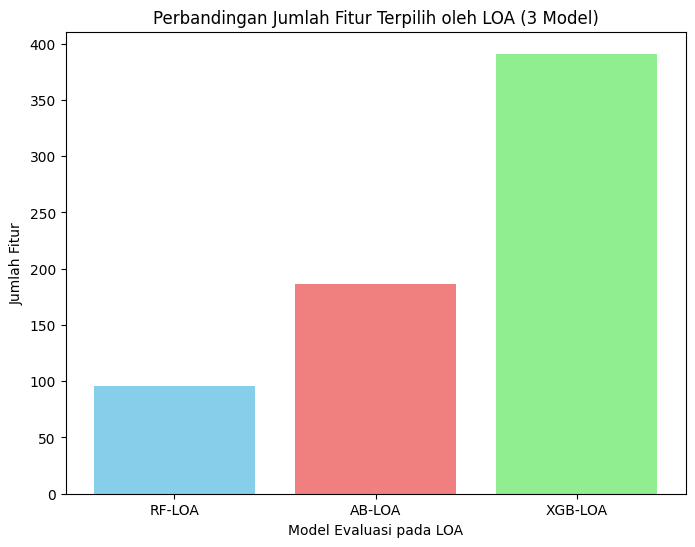

In [19]:
plt.figure(figsize=(8, 6))
model_names = ["RF-LOA", "AB-LOA", "XGB-LOA"]

feature_counts = [
    len(selected_features_rf),
    len(selected_features_ab),
    len(selected_features_xgb)
]

plt.bar(model_names, feature_counts, color=['skyblue', 'lightcoral', 'lightgreen'])
plt.title("Perbandingan Jumlah Fitur Terpilih oleh LOA (3 Model)")
plt.ylabel("Jumlah Fitur")
plt.xlabel("Model Evaluasi pada LOA")
plt.show()


Membuat Plot Convergence Curve...


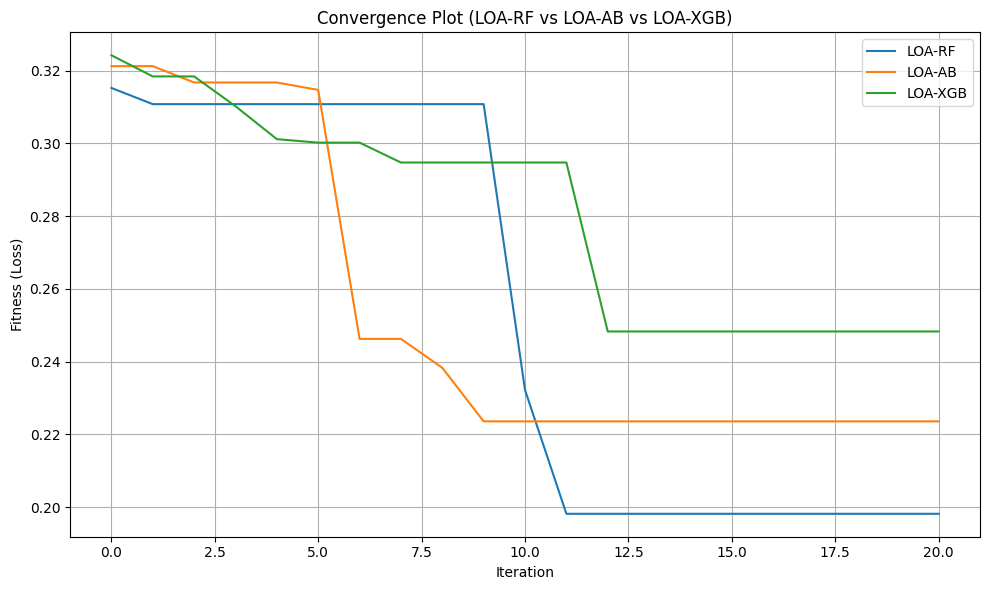

✅ Plot convergence selesai ditampilkan.


In [20]:
print("\nMembuat Plot Convergence Curve...")

plt.figure(figsize=(10, 6))

for name, curve in convergence_results.items():

    if isinstance(curve, tuple) and len(curve) == 2:
        x, y = curve
        plt.plot(x, y, label=name)
    else:
        plt.plot(curve, label=name)

plt.title("Convergence Plot (LOA-RF vs LOA-AB vs LOA-XGB)")
plt.xlabel("Iteration")
plt.ylabel("Fitness (Loss)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("✅ Plot convergence selesai ditampilkan.")